# Load `python` libraries for some EDA and wrangling

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [40]:
df_cl_mg = pd.read_csv("cleaned_merged_datasets.csv")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Check how _area_ and _price_ are distributed

In [41]:
# Distribution of area for 'Rent'
percl_area_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["area"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_area_Rent

# Distribution of area for 'Sale'
percl_area_Sale = df_cl_mg[(df_cl_mg["purpose"] == "Sale")]["area"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_area_Sale

# Distribution of prices for 'Rent'
percl_price_Rent = df_cl_mg[(df_cl_mg["purpose"] == "Rent")]["price"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_price_Rent

# Distribution of prices for 'Sale'
percl_price_Sale = df_cl_mg[(df_cl_mg["purpose"] == "Sale")]["price"].describe(percentiles=[.01, .02, .3, .6, .9, 0.95, .99])
# percl_price_Sale

In [42]:
print(percl_area_Rent, '\n\n', percl_area_Sale)

count    2.072300e+04
mean     4.241257e+03
std      1.555526e+05
min      0.000000e+00
1%       0.000000e+00
2%       0.000000e+00
30%      1.000000e+03
50%      1.400000e+03
60%      1.650000e+03
90%      3.373000e+03
95%      5.000000e+03
99%      1.200000e+04
max      1.450147e+07
Name: area, dtype: float64 

 count     12978.000000
mean       1664.862321
std        3755.222407
min           1.000000
1%          115.000000
2%          135.000000
30%        1150.000000
50%        1320.000000
60%        1445.000000
90%        2289.300000
95%        3600.000000
99%        7218.216000
max      296600.000000
Name: area, dtype: float64


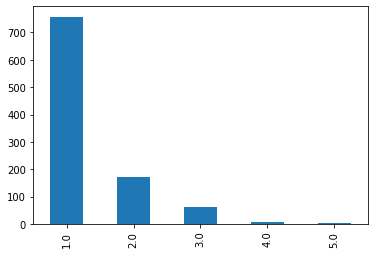

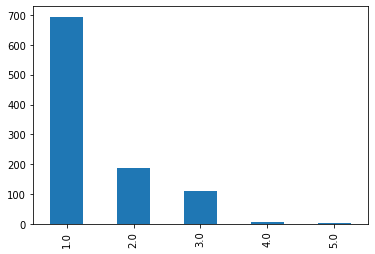

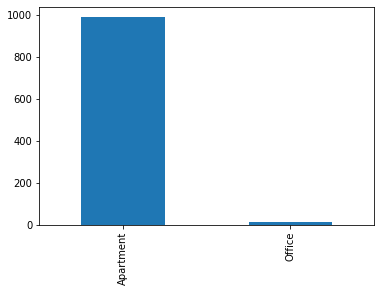

In [44]:
feature1 = 'num_bath_rooms'
feature2 = 'num_bed_rooms'
feature3 = 'building_type'

df_cl_mg[df_cl_mg.area == 0][feature1].value_counts().plot(kind = 'bar')
plt.show()

df_cl_mg[df_cl_mg.area == 0][feature2].value_counts().plot(kind = 'bar')
plt.show()

df_cl_mg[df_cl_mg.area == 0][feature3].value_counts().plot(kind = 'bar')
plt.show()

In [125]:
print(percl_price_Rent, '\n\n', percl_price_Sale)

count    2.072300e+04
mean     1.048616e+07
std      8.390854e+08
min      0.000000e+00
2%       0.000000e+00
30%      2.000000e+04
50%      3.300000e+04
60%      5.000000e+04
90%      3.800000e+05
95%      7.350000e+05
99%      2.500000e+06
max      1.000000e+11
Name: price, dtype: float64 

 count    1.297800e+04
mean     2.762862e+09
std      2.124047e+11
min      0.000000e+00
2%       2.263500e+06
30%      5.500000e+06
50%      7.350000e+06
60%      8.350000e+06
90%      2.100000e+07
95%      3.800000e+07
99%      5.423000e+09
max      2.400000e+13
Name: price, dtype: float64


In [45]:
df_cl_mg.shape

(33701, 24)

## Create "cleans" sale dataset
    . Subset to "Sale"
    . Only "Apartments"
    . Get rid of area and price outliers

In [46]:
df_sale = df_cl_mg[(df_cl_mg.purpose == 'Sale')  &
                   (df_cl_mg.building_type == 'Apartment')  &
                   (df_cl_mg.area > percl_area_Sale['1%']) & 
                   (df_cl_mg.area <= percl_area_Sale['99%']) & 
                  (df_cl_mg.price <= percl_price_Sale['95%']) &
                   (df_cl_mg.price > percl_price_Sale['2%'])
                  ][['price', 'area', 'num_bath_rooms', 'num_bed_rooms', 'zone']]

In [178]:
# df_sale['price'].describe(percentiles=[0.02, .3, .6, .9, 0.95, .99])

In [47]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,1.621415,1.516912,0.0,0.0,2.0,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data imputation & transformation

#### How many properties don't have `num_bath_rooms` info?
An apartment not having any bathrooms is very unlikely ==> these are just missing values (an error at some point in the process)

In [48]:
df_sale[df_sale.num_bath_rooms==0].shape

(4662, 5)

There are too many entries with missing `num_bath_rooms` info ( == 0) which is going to have a negative influence on estimating parameters.

Let's impute these "missing values" with the mean.

In [49]:
mean_num_bath_rooms = df_sale[df_sale.num_bath_rooms!=0].num_bath_rooms.mean()
# mean_num_bath_rooms
df_sale['num_bath_rooms'] = np.where(df_sale.num_bath_rooms==0, mean_num_bath_rooms, df_sale.num_bath_rooms)

In [51]:
# Sanity check
df_sale[df_sale.num_bath_rooms==0].shape

(0, 5)

In [52]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,2.865087,0.533222,1.0,2.865087,2.865087,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### As we saw in the EDA: the price increases non-linearly (_exponetially_) with `area` and `num_bath/bed_rooms`
==> Log transform price so that we can fit a linear model

In [55]:
df_sale['price_log'] = np.log(df_sale['price'])

In [56]:
df_sale.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,10740.0,NaN,NaN,NaN,8791256.480066,5330544.604312,2275000.0,5250000.0,7200000.0,10500000.0,38000000.0
area,10740.0,NaN,NaN,NaN,1362.240782,437.435757,250.0,1100.0,1300.0,1550.0,6357.0
num_bath_rooms,10740.0,NaN,NaN,NaN,2.865087,0.533222,1.0,2.865087,2.865087,3.0,8.0
num_bed_rooms,10740.0,NaN,NaN,NaN,2.924022,0.5266,0.0,3.0,3.0,3.0,7.0
zone,10714,53,Mirpur,3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_log,10740.0,NaN,NaN,NaN,15.843863,0.52274,14.637491,15.473739,15.789592,16.166886,17.453097


In [57]:
df_sale[df_sale.num_bed_rooms == 0].shape

(6, 6)

In [59]:
df_sale.to_csv('df-sale.csv')

<br>


# Load `R` for Linear mixed-effects models

In [64]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [72]:
%%R

# Start fresh
rm(list = ls())
ls()

character(0)


In [73]:
%%R

# Load the packages
library(Matrix)
library(lme4)

In [74]:
%%R
df.sale = read.csv("df-sale.csv")
ls()

[1] "df.sale"


In [75]:
%%R
head(df.sale)

  X    price area num_bath_rooms num_bed_rooms            zone price_log
1 0  6100000 1185       2.865087             3        Khilgaon  15.62380
2 1 28900000 2464       4.000000             3       Dhanmondi  17.17935
3 2  7500000 1140       2.865087             3          Mirpur  15.83041
4 3 20000000 1920       3.000000             3 Bashundhara R/A  16.81124
5 4 10800000 1445       3.000000             3        Khilgaon  16.19506
6 5  5000000  925       2.865087             2        Khilgaon  15.42495


In [76]:
%%R
dim(df.sale)

[1] 10740     7


In [78]:
%%R

# Make 'zone' as factor for using it as a random effect
df.sale$zone = as.factor(df.sale$zone)

### Fit an `lmer` model

In [79]:
%%R
lmer.sale.allZones = lmer(price_log ~ 
                          area + 
                          num_bath_rooms + 
                          num_bed_rooms + 
                          (1 | zone), 
                          data = df.sale)


In [80]:
%%R
summary(lmer.sale.allZones)

Linear mixed model fit by REML ['lmerMod']
Formula: price_log ~ area + num_bath_rooms + num_bed_rooms + (1 | zone)
   Data: df.sale

REML criterion at convergence: -92.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.1753  -0.5881   0.0093   0.5783   5.5183 

Random effects:
 Groups   Name        Variance Std.Dev.
 zone     (Intercept) 0.09608  0.3100  
 Residual             0.05673  0.2382  
Number of obs: 10740, groups:  zone, 54

Fixed effects:
                Estimate Std. Error t value
(Intercept)    1.440e+01  4.709e-02 305.740
area           8.449e-04  8.265e-06 102.222
num_bath_rooms 5.196e-02  5.241e-03   9.915
num_bed_rooms  9.507e-03  6.227e-03   1.527

Correlation of Fixed Effects:
            (Intr) area   nm_bt_
area         0.059              
num_bth_rms -0.165 -0.248       
num_bed_rms -0.171 -0.576 -0.234


### Save the model for generating predictions

In [81]:
%%R

saveRDS(lmer.sale.allZones, file = "lmer.sale.allZones.rds")